# Исследовательский анализ данных

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from PIL import Image
from urllib.request import urlopen

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.sample(5)

,file_name,real_age
6357,006361.jpg,28
4691,004691.jpg,23
4172,004172.jpg,43
4429,004429.jpg,13
1943,001943.jpg,25


In [4]:
len(df)

7591

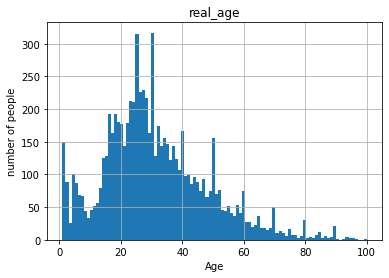

In [5]:
axarr = pd.DataFrame.hist(df, 'real_age', sharex=True, sharey=True, bins=100)
for ax in axarr.flatten():
    ax.set_xlabel("Age")
    ax.set_ylabel("number of people")

<div class="alert alert-info">
Исправил 


In [6]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Возрастов выходящих за пределы естественного не имеется, данные распределены нормально

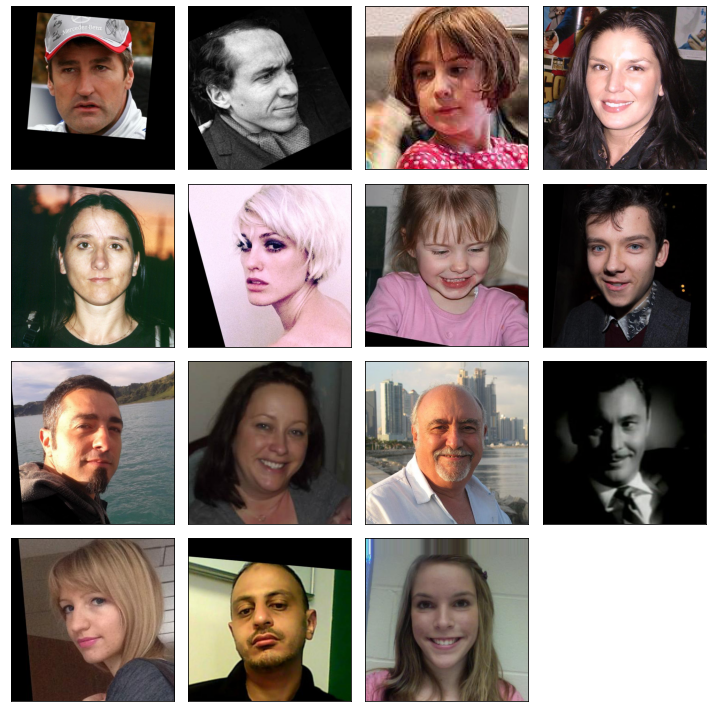

In [40]:
path = '/datasets/faces/final_files/'
fig = plt.figure(figsize=(10,10))
for num, i in enumerate(listdir('/datasets/faces/final_files/')[:15]):
    path_file = path + i
    img = Image.open(path_file)
    fig.add_subplot(4, 4, num+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


Датасет состоит из цветных и черно-белых фотографий.

In [7]:
import os
os.listdir()

['.ipynb_checkpoints',
 '0b4b635a-49a0-432c-9060-bfca641f185f.ipynb',
 '13f8ebef-66c6-4d45-9809-4dda60dbb843.ipynb',
 '1603274b-520c-4c4a-801f-710a9eef1611.ipynb',
 '17169c6f-2277-48c3-88cb-d3b18b956559.ipynb',
 '26c3a247-3425-4609-b492-e5ffea173238.ipynb',
 '31ad9e0d-f963-4723-9103-825e4196a923.ipynb',
 '3226d60b-119b-480d-85db-8f4b91043bce.ipynb',
 '3dd271fb-0f56-486d-8388-7eeaba5c2190.ipynb',
 '43d98d6a-400c-41a3-8672-60937bf5fc7b.ipynb',
 '46574d17-f0fc-4788-ab04-4ecf09e2cec2.ipynb',
 '648eafdc-a96f-44ec-b1fe-d463d86a16cb.ipynb',
 '6e51ca30-5c59-4b04-9810-2f7c0eb2b207.ipynb',
 '735e004a-7634-4b1f-88aa-f3b941278a10.ipynb',
 '75752a9f-4549-4ea9-80b7-4d72ecb227b5.ipynb',
 '7fd27dd4-b0e7-46a3-b97d-1876eb45baf1.ipynb',
 '840e9fe5-da82-4550-b9ce-887c78e548bf.ipynb',
 '8504ec1c-6ae6-4701-be10-a689ab9b6486.ipynb',
 '8b60332e-4326-467e-9aa1-f0be65ac6762.ipynb',
 'O1qi4Md3kZmzuA',
 'O1qi4Md3kZmzuA9fmo5y6k.tmp',
 'O1qi4Md3kZmzuAqfv321x3.tmp',
 'b10acf0b-4be9-45fd-8557-a0ba228acc13.ipynb',
 'b

# Обучение модели

Код для тренировки: 

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
      df = pd.read_csv(path + 'labels.csv')
      train_datagen = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip=True,
                                         width_shift_range=0.2, height_shift_range=0.2,
                                         validation_split=0.25
                                         )
      train_datagen_flow = train_datagen.flow_from_dataframe(
              dataframe = df,
              directory = path + 'final_files',
              x_col = 'file_name',
              y_col = 'real_age',
              class_mode = 'raw',
              target_size = (150,150),
              batch_size = 32,
              subset='training',
              seed=12345
              )
      return train_datagen_flow
 
def load_test(path):
      df = pd.read_csv(path + 'labels.csv')
      test_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.25
                                        )
      test_datagen_flow = test_datagen.flow_from_dataframe(
              dataframe = df,
              directory = path + 'final_files',
              x_col = 'file_name',
              y_col = 'real_age',
              class_mode = 'raw',
              target_size = (150,150),
              batch_size = 32,
              subset='validation',
              seed=12345
              )
      return test_datagen_flow
 

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
   
    model = Sequential()
    optimizer = Adam(lr=0.001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae']) #'sparse_categorical_crossentropy'
    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Модель выдает по метрике MAE 7.96, что есть модель в среднем ошибается где-то на 8 лет, полагаю, что результат не так далек от человеческого.

## Вывод

В ходе работы на наболе данных из 7591 изображений обученна нейросеть, способная определять возраст человека со средней ошибкой 8 лет.